# Helper functions

In [1]:
import d6tflow
import numpy as np

Loading postgres module without psycopg2 installed. Will crash at runtime if postgres functionality is used.


Welcome to d6tflow! For Q&A see https://github.com/d6t/d6tflow


In [2]:
X = np.random.randn(100,3)
y = np.random.randn(100,1)

In [3]:
import d6tflow
import sklearn.datasets, sklearn.ensemble, sklearn.linear_model
import pandas as pd
from pathlib import Path

In [4]:
d6tflow.settings.dirpath

WindowsPath('data')

In [11]:
# get training data and save it
class GetData(d6tflow.tasks.TaskPqPandas):    
    persist = ['x','y']

    def run(self):
        ds = sklearn.datasets.load_boston()
        df_trainX = pd.DataFrame(ds.data, columns=ds.feature_names)
        df_trainY = pd.DataFrame(ds.target, columns=['target'])
        self.save({'x': df_trainX, 'y': df_trainY}) # persist/cache training data

class GetInferenceData(d6tflow.tasks.TaskPqPandas):    
    #persist = ['x']

    def run(self):
        ds = sklearn.datasets.load_boston()
        df_trainX = pd.DataFrame(ds.data, columns=ds.feature_names)
        df_trainY = pd.DataFrame(ds.target, columns=['target'])
        #self.save({'x': df_trainX}) # persist/cache training data
        self.save(df_trainX)

# train different models to compare
@d6tflow.requires(GetData)  # define dependency
class ModelTrain(d6tflow.tasks.TaskPickle):
    model = 'ols'#d6tflow.Parameter()  # parameter for model selection

    def run(self):
        df_trainX, df_trainY = self.inputLoad()  # quickly load input data        
        if self.model=='ols':  # select model based on parameter
            model = sklearn.linear_model.LinearRegression()
        elif self.model=='gbm':
            model = sklearn.ensemble.GradientBoostingRegressor()

        # fit and save model with training score
        model.fit(df_trainX, df_trainY)
        self.save(model)  # persist/cache model
        self.saveMeta({'score': model.score(df_trainX, df_trainY)})  # save model score


def make_inference_node(train_node, inference_data_node, inference_method = 'predict_proba'):
    
    @d6tflow.requires(train_node, inference_data_node)
    class _InferenceNode(d6tflow.tasks.TaskPickle):
        
        def run(self):            
            model, inference_data = self.inputLoad().values()            
            preds = getattr(model, inference_method)(inference_data)
            self.save(preds)
            
    _InferenceNode.__name__ = f'Inference{train_node.__name__}'
    return _InferenceNode

def stack_factory(estimator, parent, inputs):
    
    @d6tflow.requires(parent, *inputs)    
    class _Node(d6tflow.tasks.TaskPickle):
        
        def run(self):
            parent_model, X, y = self.inputLoad()
            model = estimator
            

In [12]:
InferenceNode = make_inference_node(ModelTrain, GetInferenceData, inference_method = 'predict')

In [13]:
# goal: compare performance of two models
# define workflow manager
flow = d6tflow.Workflow(ModelTrain)
flow.reset_upstream(ModelTrain,confirm=False) # DEMO ONLY: force re-run
#flow.run()

#ModelTrain().run()  # execute model training including all dependencies

In [14]:
inference_flow = d6tflow.Workflow(InferenceNode)
inference_flow.reset_downstream(GetInferenceData, InferenceNode)
inference_flow.run()
inference_flow.outputLoad()


===== Luigi Execution Summary =====

Scheduled 4 tasks of which:
* 1 complete ones were encountered:
    - 1 GetInferenceData()
* 3 ran successfully:
    - 1 GetData()
    - 1 InferenceModelTrain()
    - 1 ModelTrain()

This progress looks :) because there were no failed tasks or missing dependencies

===== Luigi Execution Summary =====



array([[30.00384338],
       [25.02556238],
       [30.56759672],
       [28.60703649],
       [27.94352423],
       [25.25628446],
       [23.00180827],
       [19.53598843],
       [11.52363685],
       [18.92026211],
       [18.99949651],
       [21.58679568],
       [20.90652153],
       [19.55290281],
       [19.28348205],
       [19.29748321],
       [20.52750979],
       [16.91140135],
       [16.17801106],
       [18.40613603],
       [12.52385753],
       [17.67103669],
       [15.83288129],
       [13.80628535],
       [15.67833832],
       [13.38668561],
       [15.46397655],
       [14.70847428],
       [19.54737285],
       [20.8764282 ],
       [11.45511759],
       [18.05923295],
       [ 8.81105736],
       [14.28275814],
       [13.70675891],
       [23.81463526],
       [22.34193708],
       [23.10891142],
       [22.91502612],
       [31.35762569],
       [34.21510225],
       [28.02056414],
       [25.20386628],
       [24.60979273],
       [22.94149176],
       [22

In [15]:
scores = flow.outputLoadMeta()  # load model scores
print(scores)
# {'model1': {'score': 0.7406426641094095}, 'gbm': {'model2': 0.9761405838418584}}

{'score': 0.7406426641094094}


# d6tflow Transformer (NodeTransformer)
> a d6tflow wrapper for a sklearn estimator

In [16]:
from pathlib import Path
import os
from warnings import warn

import d6tflow
d6tflow.settings.dirpath = Path('__d6tflow__')

from sklearn.base import BaseEstimator

import cloudpickle

In [17]:
def camelize(s):
    if(len(s) == 0):
        return
    s1 = ''
    s1 += s[0].upper()        
    
    for i in range(1, len(s)):
        
        if not s[i].isalnum():
            s1 += ''
            i += 1                    
        elif (s[i] == ' '):
            s1 += s[i + 1].upper()
            i += 1
        elif(s[i - 1] != ' '):
            s1 += s[i]                
        
    while True:
        if s1[0].isnumeric():
            s1 = s1[1:] + s1[0]            
        else:
            break
            
    return s1    

def is_camel_case(s):    
    return (camelize(s) == s) and (s != '')

In [596]:
def _validate_name(name):
    #if isinstance(name,str):
    #        if is_camel_case(name):
    #            return name
    #        else:
    #            raise ValueError(f'name must be a valid camelcase str, try {camelize(name)}')
    #else:
    #    raise TypeError(f'name must be str, not {type(name)}')
    return name

# Classes

In [597]:
class Pickler():
    '''
    InputOutput Node for d6tflow application.
    Does nothing during fit.
    During transform, pickles X under `<d6tflow.settings.dirpath>/self.name` path and returns path
    '''
    def __init__(self, name):        
        self.name = _validate_name(name)        
        
        self.__path = None
        return
    
    @property
    def path(self,):                
        return self.__path        
        
    
    def pickle(self, X, override = False):
        #assigns path only after pickling, so that it raises error when trying to unpickle before pickling
        self.__path = Path(d6tflow.settings.dirpath)/'IO'/(self.name+'.pkl')
        
        #create folder if does not exist
        if not self.path.parent.exists():
            os.makedirs(self.path.parent)
        
        if override:                        
            if self.path.exists():
                warn(f'File already exists under {self.path.absolute()} and will be overriden.')                                    
            else:
                pass
        else:
            if self.path.exists():
                raise FileExistsError(f'A file already exists under {self.path.absolute()}. If you want to override, set override param to True')
            else:
                pass
        
        #override if reached this point
        with open(self.path, 'wb+') as f:
                cloudpickle.dump(X, f)                
        
        return self
    
    def unpickle(self,):
        try:
            with open(self.path, 'rb') as f:
                content = cloudpickle.load(f)
            return content
        
        except TypeError as e:
            raise TypeError(str(e)+ '. Check if path is valid or not None. If so try running .pickle() before trying to unpickle')
            
    
    def force_unpickle(self, file_path):
        '''
        forced unpickling of file in file_path
        '''
        with open(file_path, 'rb') as f:
            content = cloudpickle.load(f)
        return content
    
    def reset(self,):
        '''
        deletes pickled file under path
        '''
        if self.path.exists():
            os.remove(self.path)        
        self.__path = None
        return self

In [598]:
class PicklerTransformer(Pickler, BaseEstimator):
    '''
    Sklearn verstion of Pickler
    during fit, pickles a dict containing X, y and kwargs passed to fit
    on trnsform, unpickles and returns the dict
    '''
    def __init__(self, name, override_on_fit = False):
        self.override_on_fit = override_on_fit
        super().__init__(name)
        return
    
    def fit(self, X, y = None, **kwargs):
        output_dict = {'X':X, 'y':y, 'kwargs':kwargs}        
        self.pickle(output_dict, override = self.override_on_fit)
        self.is_fitted_ = True
        return self
    
    def transform(self, X = None, **kwargs):
        return self.unpickle()
    
    def reset(self,):
        super().reset()
        self.is_fitted_ = False
        return self

# Task Factories

In [599]:

def _process_multiple_kwargs(kwargs_list):
    '''
    takes a list of kwargs and returns a kwargs dict with parameters as lists
    '''
    
    keys = []
    for kwargs in kwargs_list:
        keys += list(kwargs.keys())
    
    keys = list(set(keys))
    #dict will contain __EMPTY_KW_PARAM__ if parameter has not been passed
    dict_kwargs = {key:['__EMPTY_KW_PARAM__']*len(kwargs_list) for key in keys}
    
    for idx in range(len(kwargs_list)):
        kwargs = kwargs_list[idx]
        for key in kwargs:
            dict_kwargs[key][idx] = kwargs[key]
    
    return dict_kwargs

def unpack_fit_inputs(inputs):
    '''
    unpacks result of Task.inputLoad(), according to defined convention for fit tasks
    returns tuple (X, kwargs)
    '''    
    if len(inputs) < 1:
        raise ValueError('No inputs to unpack')
    
    #checks if keys contains X y and kwargs
    if (set(['X', 'kwargs']) & set(inputs.keys())) == set(['X', 'kwargs']):
        #keep as list even for single inputs for consistency
        X, kwargs = [inputs['X']], [{k:v for k,v in inputs.items() if not k == 'X'}]
    
    else:
        X, kwargs = [], []   
        for key in inputs:
            X.append(inputs[key]['X'])            
            kwargs.append({k:v for k,v in inputs[key].items() if not k == 'X'})
    
        kwargs = _process_multiple_kwargs(kwargs)
    
    return X, kwargs

def unpack_transform_inputs(inputs):
    '''
    unpacks result of Task.inputLoad(), according to defined convention for transform tasks
    returns tuple (estimator, X, kwargs)
    '''
    
    if len(inputs) < 1:
        raise ValueError('No inputs to unpack')
            
    #retrieves estimator (will always be dict since transform needs at least 
    #two inputs always: estimator (from fit) and input)    
    estimator = inputs[0]
    #remove estimator from inputs
    del inputs[0]
    
    X, kwargs = unpack_fit_inputs(inputs)
    
    return estimator, X, kwargs

In [600]:
#TODO: disable fit and transform method for singletons (using @property ro raise a erro when attr called), enable only in pipeline
def input_task_factory(task_name, **kwargs):
    '''
    task to dump any object as a pkl file
    '''    
    class DumpTask(d6tflow.tasks.TaskPickle):
        def run(self,):            
            self.save(kwargs)
            return
    
    DumpTask.__name__ = _validate_name(task_name)
    return DumpTask    

def fit_task_factory(task_name, estimator, dependencies = [], y_task = None):
    '''
    creates a task to fit estimator    
    '''
    assert isinstance(dependencies, (list, tuple)), f'dependencies should be tuple or list, not {type(dependencies)}'
        
    class FitTask(d6tflow.tasks.TaskPickle):
        def run(self,):
            inputs = self.inputLoad()
            #reset and rerun y_loader
            y_task().reset(confirm = False)
            y_task().run()
            y = y_task().outputLoad()
            X, kwargs = unpack_fit_inputs(inputs)
            estimator.fit(X, y, **kwargs)            
            self.save(estimator)
            return
    
    #different syntax for @requires wrapper    
    if len(dependencies) > 0:        
        FitTask = d6tflow.requires(*dependencies)(FitTask)
    
    FitTask.__name__ = _validate_name(task_name)
    return FitTask

def transform_task_factory(task_name, fit_task, input_dependencies = [], transform_method = 'transform'):
    '''
    receives X and **kwargs from dependencies, performs and saves result from estimator.transform()
    '''
    assert isinstance(input_dependencies, (list, tuple)), f'dependencies should be tuple or list, not {type(input_dependencies)}'
    
    class TransformTask(d6tflow.tasks.TaskPickle):
        def run(self,):
            inputs = self.inputLoad()
            estimator, X, kwargs = unpack_transform_inputs(inputs)
            results = getattr(estimator, transform_method)(X, **kwargs)
            self.save({'X':results})
            return
    
    
    TransformTask = d6tflow.requires(fit_task, *input_dependencies)(TransformTask)
    
    TransformTask.__name__ = _validate_name(task_name)
    return TransformTask

# Wrappers
> make to main wrappers: Skleaern way and keras way

In [601]:
def _validate_input_nodes(input_nodes, child_name):
    '''
    checks if input nodes are valid (NodeTransformer).
    If not NodeTransformer but valid BaseEstimator instance, wrapps BaseEstimator in NodeTransformer
    '''
        
    processed_nodes = []
    for node in input_nodes:
        if isinstance(node, NodeTransformer):
            processed_nodes.append(node)
        
        elif isinstance(node, BaseEstimator):
            node = NodeTransformer(node, 'Parent' + child_name)
            process_nodes.append()

In [622]:
from sklearn.exceptions import NotFittedError

class BaseDagNode(BaseEstimator):
    '''
    Base class for nodes
    '''
    pass

class InputTransformer(BaseDagNode):
    
    def __init__(self, name = None, reset_cache = True):
                        
        self.reset_cache = reset_cache
        
        if name is None:
            self.name = 'Input' + str(id(self))
        else:
            self.name = _validate_name(name)
        #input task placeholder, to access this task, fit_task and input_task aliases will be created, for consistency
        self.__input_task = None
        return
    
    @property
    def input_task(self,):
        
        if self.__input_task is None:
            raise NotFittedError(f'Input node "{self.name}" is not fitted')
        else:            
            return self.__input_task
            
    @property
    def fit_task(self,):
        return self.input_task
    
    @property
    def transform_task(self,):
        return self.input_task
    
    def fit(self, X, **kwargs):        
        '''
        creates input task. saves kwargs
        '''
        kwargs = {'X':X, **kwargs}
        self.__input_task = input_task_factory(self.name, **kwargs)
        self.is_fitted = True
        return self
    
    def transform(self, X = None, reset_cache = None, **kwargs):        
        self.input_task.reset(confirm = False)
        self.input_task.run()
        result = self.input_task.outputLoad()
        if reset_cache is None:
            #if none is passed, use defaut value from constructor
            reset_cache = self.reset_cache
        if reset_cache:
            self.input_task.reset(confirm = False)
        return result
    
    
class NodeTransformer(BaseDagNode):
    
    def __init__(self, estimator, input_nodes = [], name = None):
        
        self.estimator = estimator
        
        if not isinstance(input_nodes, (list, tuple)) and (len(input_nodes) > 0):
            raise TypeError(f'input_nodes should be a list or tuple with length greater than 0, got {input_nodes}')
        self.input_nodes = input_nodes
        
        if name is None:
            self.name = 'Task' + str(id(self))
        else:
            self.name = _validate_name(name)                                        
        
        #placeholder for __y_loader
        self.__y_loader = None
        
        return
    
            
    def set_y_loader(self, y_loader):
        '''
        sets self.__y_loader, needed during fit
        '''
        self.__y_loader = y_loader
        return
    
    @property
    def y_loader(self,):
        return self.__y_loader
    
    @property
    def fit_task(self,):
        if self.y_loader is None:
            raise NotFittedError('Should set y_loader prior to accessing fit_task')
        return fit_task_factory('Fit' + self.name, self.estimator, [i.transform_task for i in self.input_nodes], self.y_loader)
        
    @property
    def transform_task(self,):        
        return transform_task_factory('Transform' + self.name, self.fit_task, [i.transform_task for i in self.input_nodes])        
    
    def _fit(self,):        
        
        #reset cache of transform nodes
        #TODO: is it necessary? better reset inside pipeline since this estimators are not suposed to be used outside pipeline
        [node.transform_task().reset(confirm = False) for node in self.input_nodes]
        self.fit_task().reset(confirm = False)
        #run task
        d6tflow.Workflow(self.fit_task).run()        
        return self
    
    def fit(self, X, y = None, **kwargs):
        raise NotImplementedError
    
    def _infer(self, X, infer_method, **kwargs):
        #create Task with dependencies
        self._make_transform_task()
        #reset cache
        [node.transform_task().reset(confirm = False) for node in self.input_nodes]
        self.transform_task().reset(confirm = False)
        #run task
        workflow = d6tflow.Workflow(self.transform_task)
        workflow.run()        
        return getattr(workflow.outputLoad(), infer_method)(X, **kwargs)
    
    def transform(self, X, **kwargs):
        return self._infer(X, infer_method = 'transform', **kwargs)
        

# Graph functionalities

In [623]:
#do something like Keras Model (compile before run)
#to pickle, make folder structure , setting folder name as graph name

# PipelineSession

In [624]:

class PipelineSession():
    '''
    sets d6tflow.settings.dirpath to pipeline name on open
    on close, resets d6tflow.settings.dirpath to default
    '''
    def __init__(self, pipeline_name):
        self.session_name = Path(pipeline_name)
        self.default_name = d6tflow.settings.dirpath
        return
    
    def __enter__(self,):
        d6tflow.settings.dirpath = self.session_name
        return
    
    def __exit__(self, exc_type, exc_value, traceback):
        d6tflow.settings.dirpath = self.default_name
        return
    
        
    

# Serialization functionalities

In [625]:
from pathlib import Path
from collections import defaultdict

def pickle_load(path, **kwargs):
    '''
    abstraction for loading object
    '''
    path = Path(path)
    try:
        with open(path.absolute(), 'rb') as f:
             obj = cloudpickle.load(f, **kwargs)
        
    except Exception as e:            
        raise Exception(f'{str(e)} [{path.absolute()}]')
    
    return obj

def pickle_dump(obj, path, **kwargs):
    '''
    abstraction for dumping objects
    '''
    path = Path(path)
    try:
        with open(path.absolute(), 'wb') as f:
             cloudpickle.dump(obj, f, **kwargs)                            
        
    except Exception as e:            
        raise Exception(f'{str(e)} [{path.absolute()}]')
    
    return


def recursive_dict():
    return defaultdict(recursive_dict)

def undefault_dict(dictionary):
    '''
    recursively transforms a default dicts into dicts
    '''
    for key in dictionary.keys():
        if isinstance(dictionary[key], defaultdict):
            dictionary[key] = undefault_dict(dict(dictionary[key]))
        
        elif isinstance(dictionary[key], dict):
            dictionary[key] = undefault_dict(dictionary[key])
        
        else:            
            return dictionary
    
    dictionary = dict(dictionary)
    return dictionary
            
def recursive_assign(dictionary, keys, value):
    
    '''
    assigns value to dictinary[keys[0]][keys[1]]...[keys[n]] position    
    '''
    
    if len(keys) == 1:
        dictionary[keys[0]] = value
        return dictionary
    
    else:
        dictionary[keys[0]] = recursive_assign(dictionary[keys[0]], keys[1:], value)
    
    return dictionary

def folder_to_dict(root_folder, patterns = ['*.pickle','*.pkl','*.sav']):
    
    '''
    creates a dict of unpickled objects found recursively under root folder and matching patterns
    '''
        
    obj_dict = {}
    root_folder = Path(root_folder)
    
    file_paths = []
    for pattern in patterns:
        file_paths += root_folder.rglob(pattern)
    
    for path in file_paths:        
        obj = pickle_load(path)
        obj_dict[str(path)] = obj
    
    return obj_dict

def dict_to_folder(dictionary, path = '.', assert_new_folder = True, override = False):
    
    '''
    creates folder structure according to dictionary. Can ensure that no folders with the same name 
    are found under path and to raise errors in case the same filenames already exists.
    '''
    root_path = Path(path)
    for key in dictionary:
        
        filepath = Path(key)        
        if assert_new_folder:
            dirpath = root_path/filepath.parts[0]
            if dirpath.exists():
                raise FileExistsError(f'{dirpath.absolute()} already exists.')        
        
        filepath = root_path/filepath
        if filepath.exists():
            if override:
                warn(f'{filepath.absolute()} already exists and will be overriden.')                
            else:
                raise FileExistsError(f'{filepath.absolute()} already exists.')
        
        pickle_dump(dictionary[key], filepath)
            
    return

# Model

In [626]:
def _traverse_upstream(output_node):  
    '''
    traverses all nodes in the dag that ends at output_node.
    returns nodes and directed edges
    '''
    def __traverse_upstream(node, traversed_nodes = [], traversed_edges = []):
        
        assert isinstance(node, BaseDagNode)
        
        traversed_nodes.append(node)
        
        if not isinstance(node, InputTransformer): #keep traversing until reaches an InputNode
            
            for input_node in node.input_nodes:
                traversed_edges.append((input_node, node))
                __traverse_upstream(input_node, traversed_nodes)        

        return traversed_nodes, traversed_edges
    
    traversed_nodes, traversed_edges = __traverse_upstream(output_node)
    return traversed_nodes, traversed_edges

True

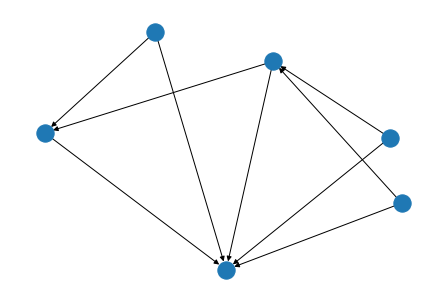

In [627]:
from sklearn.preprocessing import FunctionTransformer
import networkx as nx

in1 = InputTransformer('Input1')
in2 = InputTransformer('Input2')
in3 = InputTransformer('Input3')

node1 = NodeTransformer(FunctionTransformer(), [in1,in2])
node2 = NodeTransformer(FunctionTransformer(), [node1,in3])
node3 = NodeTransformer(FunctionTransformer(), [node1,node2,in1, in2, in3])

nodes, edges = _traverse_upstream(node3)

g = nx.DiGraph()

g.add_nodes_from(nodes)
g.add_edges_from(edges)

nx.draw(g)
nx.is_directed_acyclic_graph(g)

In [628]:
import networkx as nx
from sklearn.base import clone

class DAGEstimator(BaseDagNode):
    
    def __init__(self, output_node, name):        
        self.output_node = output_node
        self.name = _validate_name(name)                
        return                                
    
    @property
    def graph(self,):
        return self.__graph
    
    @property
    def input_nodes_list(self,):
        return [i for i in self.__graph if isinstance(i, InputTransformer)]
    
    @property
    def input_nodes_dict(self,):
        return {i.name:i for i in self.__graph if isinstance(i, InputTransformer)}
    
    def session_run(self, method):
        '''
        runs a method safely inside a pipelinesession
        '''
        
        def session_wrapped_method(*args, **kwargs):
            with PipelineSession(pipeline_name = self.name):
                result = method(*args, **kwargs)
            return result
            
        return session_wrapped_method
        
    
    def _make_graph(self):                
        nodes,edges = _traverse_upstream(self.output_node)
        
        g = nx.DiGraph()
        g.add_nodes_from(nodes)
        g.add_edges_from(edges)
        self.__graph = g
        return
    
    def _check_graph(self,):
        
        if not nx.is_connected(nx.Graph(self.__graph)):
            raise Exception('DAG has disconected parts')
        
        
        if not nx.is_directed_acyclic_graph(self.__graph):
            raise Exception('Infered graph is not a DAG')
        
        
        repeated_names = set(
            [x.name for x in list(self.graph.nodes) if [i.name for i in self.graph.nodes].count(x.name) > 1])
        if repeated_names:
            raise NameError(f'Node names should be unique. Got repeated names: {repeated_names}')
        
        return True    
    
    def _fit(self, X, y = None, **kwargs):
        '''
        X must be a list or dict pointing to input Nodes
        '''
        self._make_graph()
        self._check_graph()
        #check inputs
        if isinstance(X, list):
            if len(X) != len(self.input_nodes_list):
                raise ValueError(f'DAG has {len(self.input_nodes_list)} input nodes, got {len(X)} inputs in X')
        
        elif isinstance(X, dict):                        
            if set(X) == set(self.input_nodes_dict):
                raise ValueError(f'DAG input node names are {set(self.input_nodes_dict)}, got {set(X)} keys in X')
        
        else:
            raise TypeError(f'X should be list of inputs or dict, got {type(X)}')
        
        
        y_loader = input_task_factory(self.name + 'Y', y = y)
        #pass y to all transformers in the pipeline
        for node in self.__graph:
            #if not input node, assign y
            if isinstance(node, NodeTransformer):
                node.set_y_loader(y_loader)
                            
        
        if isinstance(X, list):
            for idx in range(len(self.input_nodes_list)):
                
                #TODO: define how to pass **kwargs for each input node
                self.input_nodes_list[idx].fit(X[idx])
        
        elif isinstance(X, dict):
            for key in range(len(self.input_nodes_dict)):
                self.input_nodes_dict[key].fit(X[key])
            
                                    
        self.output_node._fit()
        
        #TODO: check if it will be necessary to clone in order to grab different parts of the pipeline and reuse it in other pipelines (like in keras)        
        return self
    
    def fit(self, X, y = None, **kwargs):
        self.session_run(self._fit)(X, y = None, **kwargs)
    
    def _infer():
        return
    
    def _reduce_dag():
        '''
        creates a dictionary with all reference for reconstructing the dag (for serializing purposes)
        '''
        return
    
    def _reduce_states():
        '''
        creates a dict of objects, with their relative paths as keys , to pickle pipeline
        '''
        #node.fit_task().output().path <--- obj paths
    

In [633]:
in1 = InputTransformer()
in2 = InputTransformer()
in3 = InputTransformer()

node1 = NodeTransformer(FunctionTransformer(), [in2,in1])
node2 = NodeTransformer(FunctionTransformer(), [node1,in3])
node3 = NodeTransformer(FunctionTransformer(), [node1,node2,in1, in2, in3])

node4 = NodeTransformer(FunctionTransformer(lambda x: sum(x)), [node1,node3,in1, in2, in3])

In [634]:
#dag = DAGEstimator(node3, 'Pipeline1')
dag.fit(['a','b','c'])


===== Luigi Execution Summary =====

Scheduled 8 tasks of which:
* 8 ran successfully:
    - 1 FitTask2926978687496()
    - 1 FitTask2926978688520()
    - 1 FitTask2926978690760()
    - 1 Input2926978688904()
    - 1 Input2926978690120()
    ...

This progress looks :) because there were no failed tasks or missing dependencies

===== Luigi Execution Summary =====



In [ ]:
#TODO: reset cache during fit and transform